# Trajectory prediction

It is your task as Flight Operations Engineer researcher to develop different trajectory prediction 
algorithms. The goal is to predict the position of the aircraft in the next 10 minutes from any point. For this 
reason, different models should be evaluated to propose to Eurocontrol which one should be explored 
further. 
The following restrictions apply to the problem:
1. EDA + plots
2. Data cleaning and variable conversion is expected. 
3. Regression algorithm + another (explain which and why)
5. You should predict the trajectory in the next 10 minutes from a selected point.
a. 4D Output : Latitude, longitude, altitude, and time
b. Show the degradation (or improvement of the solution) 
6. Your justification of selected parameters used in your algorithm predictor should be validated 
using statistical tools or techniques such as feature engineering or any other you think is valid. 
An explanation is expected.
7. You must justify the quality of your model using tools such as residuals, F statistics, or any 
relevant tool. 


The optimization is divided as follows:
* Data initialization;
* Data-type conversion;
* Data cleaning & variable conversion;
* Data splitting:
    - Climb;
    - Enroute;
    - Descent;
* Data plotting & visualisation;
* Regression models

### Data initialization

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [10]:
file_location = r'/Users/thgroenewoud/python_shizzle/all_flights '
flight_files = []

for i in range(1, 26):
    file_path = os.path.join(file_location, f"File_{i}.csv")
    
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
    else:
        flight_files.append(pd.read_csv(file_path, low_memory=False))


### Initial data cleaning

Making the data ready for data analysis

Drop column 'Unnamed', 'hour' and 'callsign'.
Change timestamp and last_position to datetime

In [11]:
for i in range(len(flight_files)):
    flight_files[i]['timestamp'] = pd.to_datetime(flight_files[i]['timestamp'], errors='coerce')
    flight_files[i]['last_position'] = pd.to_datetime(flight_files[i]['last_position'], errors='coerce')
    flight_files[i]['icao24'] = flight_files[i]['icao24'].astype(str)
    flight_files[i].drop(columns = ['Unnamed: 0', 'hour', 'callsign'], inplace = True)

In [12]:
flight_files[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083774 entries, 0 to 1083773
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   timestamp      1083774 non-null  datetime64[ns]
 1   icao24         1083774 non-null  object        
 2   latitude       1083774 non-null  float64       
 3   longitude      1083774 non-null  float64       
 4   ground_speed   1061121 non-null  float64       
 5   track          1061121 non-null  float64       
 6   vertical_rate  1061121 non-null  float64       
 7   onground       1083774 non-null  bool          
 8   alert          1083774 non-null  bool          
 9   spi            1083774 non-null  bool          
 10  squawk         988737 non-null   float64       
 11  baro_altitude  1026550 non-null  float64       
 12  altitude       1020215 non-null  float64       
 13  last_position  1083774 non-null  datetime64[ns]
dtypes: bool(3), datetime64[ns](2), flo

Based on the condition of the difference between the 'timestamp' and 'last-position'. If bigger than 2 seconds, delete row.

In [13]:
for i in range(len(flight_files)):
    time_difference = (flight_files[i]['timestamp'] - flight_files[i]['last_position']).dt.total_seconds()
    flight_files[i] = flight_files[i][time_difference <= 2].copy()
    flight_files[i].drop(columns=['last_position'], inplace=True)

Split data in groups

In [14]:
for i in range(len(flight_files)):
    flight_files[i] = flight_files[i].drop(flight_files[i][flight_files[i]['onground']].index)

    flight_files[i]['timestamp_delta'] = flight_files[i]['timestamp'].diff().dt.total_seconds()
    x_seconds_threshold = 60 * 15
    flight_files[i]['group'] = (flight_files[i]['timestamp_delta'] >= x_seconds_threshold).cumsum()

    flight_files[i]['group'] = flight_files[i]['group'].mask(flight_files[i]['timestamp_delta'] >= x_seconds_threshold)
    flight_files[i].reset_index(drop=True, inplace=True)
    # Starting from group 0
    flight_files[i]['group_duration'] = flight_files[i].groupby('group')['timestamp_delta'].transform('sum') / 3600

In [15]:
flight_files[0]

,timestamp,icao24,latitude,longitude,ground_speed,track,vertical_rate,onground,alert,spi,squawk,baro_altitude,altitude,timestamp_delta,group,group_duration
0,2022-10-01 17:28:44,4853d1,52.303333,4.766006,NaN,NaN,NaN,False,False,False,2115.0,35000.0,NaN,NaN,0.0,2.559167
1,2022-10-01 17:28:51,4853d1,52.303418,4.766536,NaN,NaN,NaN,False,False,False,2115.0,35000.0,NaN,7.0,0.0,2.559167
2,2022-10-01 17:32:55,4853d1,52.300508,4.766968,83.528366,238.212747,0.0,False,False,False,2115.0,150.0,NaN,244.0,0.0,2.559167
3,2022-10-01 17:32:56,4853d1,52.300275,4.766262,87.132008,238.134022,0.0,False,False,False,2115.0,150.0,150.0,1.0,0.0,2.559167
4,2022-10-01 17:32:57,4853d1,52.300003,4.765625,87.132008,238.134022,0.0,False,False,False,2115.0,150.0,150.0,1.0,0.0,2.559167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941170,2022-10-30 22:03:50,484133,52.301456,4.763775,141.226646,183.247343,0.0,False,False,False,7455.0,NaN,NaN,1.0,150.0,1.790278
941171,2022-10-30 22:04:08,484133,52.302967,4.767551,141.226646,183.247343,0.0,False,False,False,7124.0,NaN,NaN,18.0,150.0,1.790278
941172,2022-10-30 22:04:09,484133,52.302967,4.767551,141.226646,183.247343,0.0,False,False,False,7124.0,NaN,NaN,1.0,150.0,1.790278
941173,2022-10-30 22:04:40,484133,52.305061,4.769783,141.226646,183.247343,0.0,False,False,False,7124.0,NaN,NaN,31.0,150.0,1.790278


In [16]:
flight_files[0][['latitude','longitude','ground_speed','track','vertical_rate','baro_altitude','group_duration']].describe()

,latitude,longitude,ground_speed,track,vertical_rate,baro_altitude,group_duration
count,941175.000000,941175.000000,940129.000000,940129.000000,940129.000000,937763.000000,941025.000000
mean,46.262672,-7.279982,413.035728,165.984907,43.540442,28490.706927,-49.770216
std,4.563408,29.286959,92.631771,136.418931,1142.630710,12631.309374,180.807052
min,25.908829,-118.706939,58.591758,0.000000,-18880.000000,-1000.000000,-703.117500
25%,42.550186,1.104093,384.724244,27.734191,-64.000000,20400.000000,1.734167
50%,46.616759,1.645203,443.785601,140.954107,0.000000,36000.000000,1.841667
75%,50.342009,3.608407,472.546944,341.075356,64.000000,37000.000000,1.962778
max,52.640625,19.834290,1125.599312,359.890027,26624.000000,117300.000000,4.833056


In [17]:
group_row_counts = flight_files[0].groupby('group').size()
print(group_row_counts.mean())

6231.953642384106


## Data exploration

In this chapter, the data is explored among:
- Flight duration
- Vertical rates
- Latitude & longitude
- Starting (LEBL) and ending (EHAM) coordinates
- Ground speed
- Track
- Altitudes

In [18]:
selected_flight = flight_files[0][flight_files[0]['group'] == 2.0]

Longitude

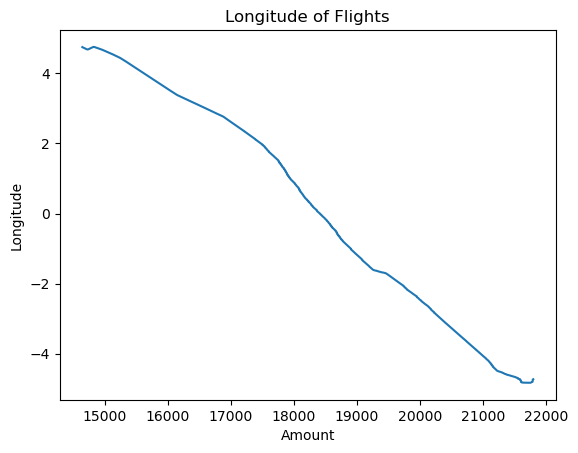

In [19]:
plt.plot(selected_flight['longitude'])
    
plt.xlabel('Amount')
plt.ylabel('Longitude')
plt.title('Longitude of Flights')
plt.show()

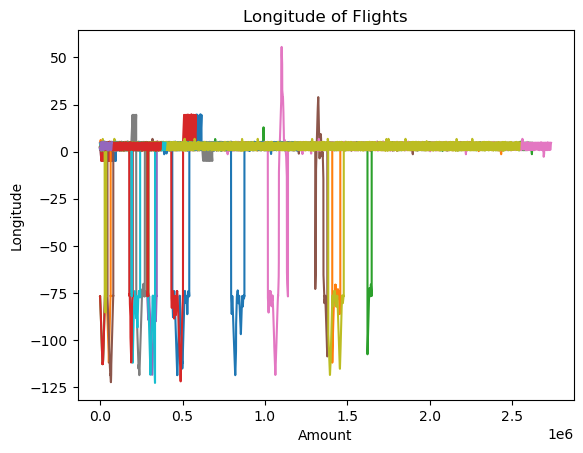

In [20]:
for i in range(len(flight_files)):
    plt.plot(flight_files[i]['longitude'])
    
plt.xlabel('Amount')
plt.ylabel('Longitude')
plt.title('Longitude of Flights')
plt.show()

Latitude

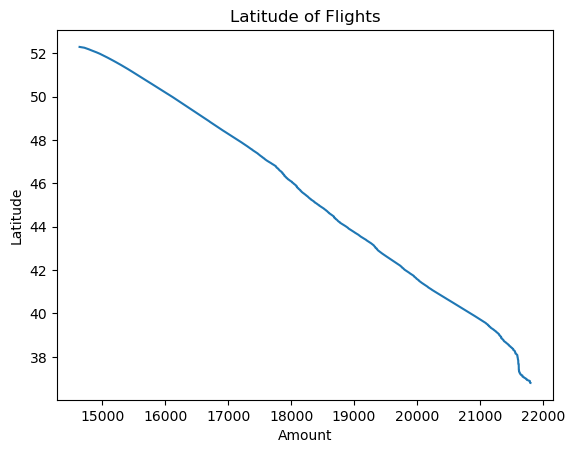

In [21]:
plt.plot(selected_flight['latitude'])

plt.xlabel('Amount')
plt.ylabel('Latitude')
plt.title('Latitude of Flights')
plt.show()

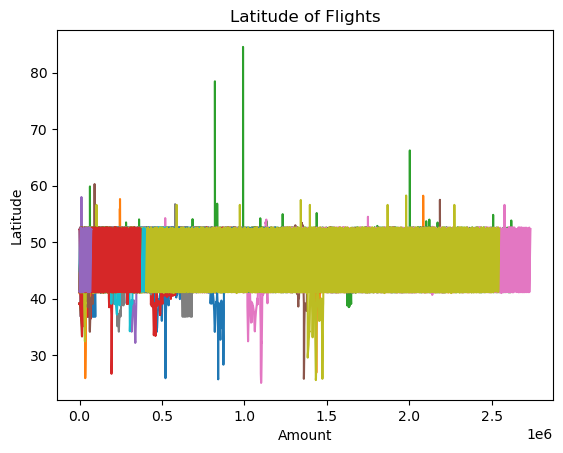

In [22]:
for i in range(len(flight_files)):
    plt.plot(flight_files[i]['latitude'])

plt.xlabel('Amount')
plt.ylabel('Latitude')
plt.title('Latitude of Flights')
plt.show()

Longitude vs latitude

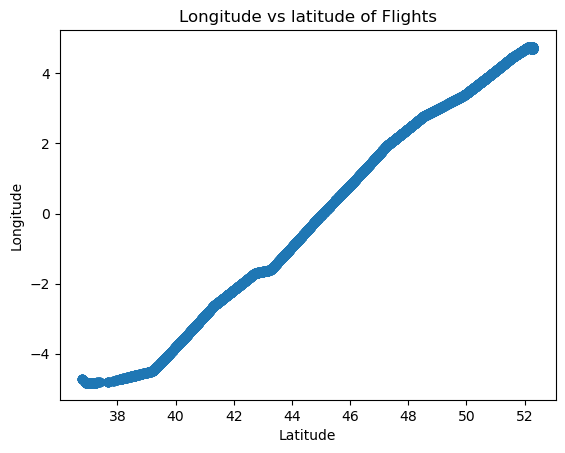

In [23]:
plt.scatter(selected_flight['latitude'], selected_flight['longitude'])
    
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Longitude vs latitude of Flights')
plt.show()

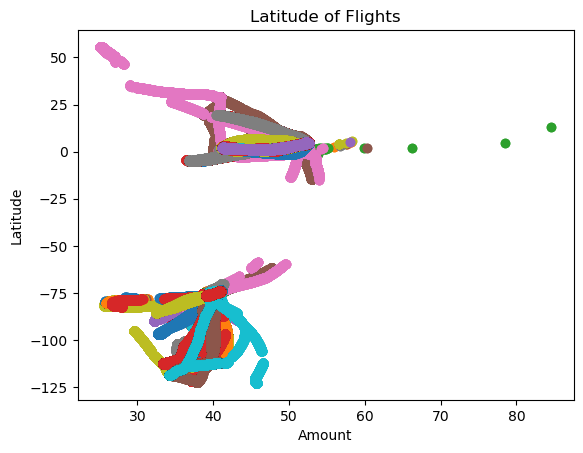

In [24]:
for i in range(len(flight_files)):
    plt.scatter(flight_files[i]['latitude'], flight_files[i]['longitude'])
    
plt.xlabel('Amount')
plt.ylabel('Latitude')
plt.title('Latitude of Flights')
plt.show()

Altitudes

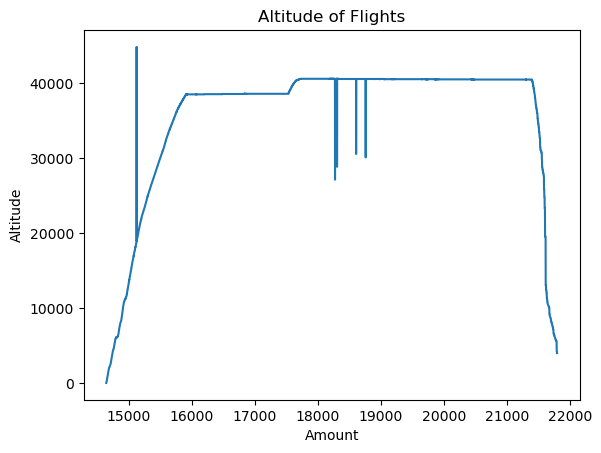

In [25]:
plt.plot(selected_flight['altitude'])

plt.xlabel('Amount')
plt.ylabel('Altitude')
plt.title('Altitude of Flights')
plt.show()

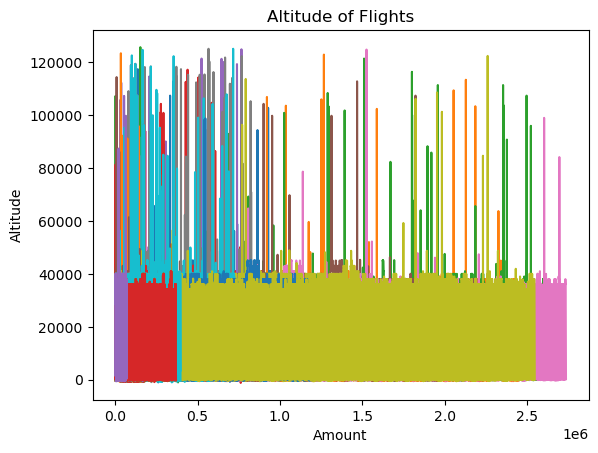

In [26]:
for i in range(len(flight_files)):
    plt.plot(flight_files[i]['baro_altitude'])

plt.xlabel('Amount')
plt.ylabel('Altitude')
plt.title('Altitude of Flights')
plt.show()

## Data cleaning

In [27]:
for i in range(len(flight_files)):
    duration_filter = (flight_files[i]['group_duration'] >= 1.5) & (flight_files[i]['group_duration'] <= 2.5)
    icao24_unique_filter = flight_files[i].groupby('group')['icao24'].transform('nunique') == 1
    vertrate_filter = (flight_files[i]['vertical_rate'] >= -3000) & (flight_files[i]['vertical_rate'] <= 3000)


    combined_filter = icao24_unique_filter & duration_filter & vertrate_filter
    
    flight_files[i] = flight_files[i][combined_filter]
    flight_files[i] = flight_files[i].drop(columns=['alert', 'spi', 'squawk', 'timestamp_delta', 'onground'])
    flight_files[i] = flight_files[i].reset_index(drop=True)

In [28]:
flight_files[0]

,timestamp,icao24,latitude,longitude,ground_speed,track,vertical_rate,baro_altitude,altitude,group,group_duration
0,2022-10-05 09:25:37,484186,52.294503,4.751979,158.473836,238.416183,1088.0,25.0,25.0,2.0,2.411944
1,2022-10-05 09:25:38,484186,52.294084,4.750017,158.473836,238.416183,1408.0,50.0,50.0,2.0,2.411944
2,2022-10-05 09:25:39,484186,52.293686,4.748993,158.999863,238.109208,1664.0,100.0,75.0,2.0,2.411944
3,2022-10-05 09:25:40,484186,52.293293,4.747899,158.151689,237.917813,1920.0,100.0,100.0,2.0,2.411944
4,2022-10-05 09:25:41,484186,52.292908,4.746933,158.685086,237.611885,2048.0,125.0,125.0,2.0,2.411944
...,...,...,...,...,...,...,...,...,...,...,...
676066,2022-10-30 22:03:50,484133,52.301456,4.763775,141.226646,183.247343,0.0,NaN,NaN,150.0,1.790278
676067,2022-10-30 22:04:08,484133,52.302967,4.767551,141.226646,183.247343,0.0,NaN,NaN,150.0,1.790278
676068,2022-10-30 22:04:09,484133,52.302967,4.767551,141.226646,183.247343,0.0,NaN,NaN,150.0,1.790278
676069,2022-10-30 22:04:40,484133,52.305061,4.769783,141.226646,183.247343,0.0,NaN,NaN,150.0,1.790278


In [29]:
flight_files[0]['group'].nunique()

113